## 4.인공 신경망의 이해 III 강의 노트 (수정)

In [ ]:
import numpy as np
import sys

class NeuralNetMLP:
    def __init__(self, n_hidden=30, l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):
      self.random = np.random.RandomState(seed)
      self.n_hidden = n_hidden
      self.l2 = l2
      self.epochs = epochs
      self.eta = eta
      self.shuffle = shuffle
      self.minibatch_size = minibatch_size

    def _oneshot(self, y, n_classes):
      onehot = np.zeros((n_classes, y.shape[0]))
      for idx, val in enumerate(y.astype(int)):
        onehot[val, idx] = 1.
      return onehot.T

    def _sigmoid(self, z):
      return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
      z_h = np.dot(X, self.w_h) + self.b_h

      a_h = self._sigmoid(z_h)

      z_out = np.dot(a_h, self.w_out) + self.b_out

      a_out = self._sigmoid(z_out)

      return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
      L2_term = (self.l2 *
                 (np.sum(self.w_h ** 2.) +
                  np.sum(self.w_out ** 2.)))
      term1 = -y_enc * (np.log(output))
      term2 = (1. - y_enc) * np.log(1. - output)
      cost = np.sum(term1 - term2) + L2_term
      return cost

    def predict(self, X):
      z_h, a_h, z_out, a_out = self._forward(X)
      y_pred = np.argmax(z_out, axis=1)
      return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
      n_output = np.unique(y_train).shape[0]
      n_features = X_train.shape[1]

      self.b_h = np.zeros(self.n_hidden)
      self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                    size=(n_features, self.n_hidden))

      self.b_out = np.zeros(n_output)
      self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                      size=(self.n_hidden, n_output))

      epoch_strlen = len(str(self.epochs))
      self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

      y_train_enc = self._oneshot(y_train, n_output)

      for i in range(self.epochs):

        indices = np.arange(X_train.shape[0])

        if self.shuffle:
          self.random.shuffle(indices)

        for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
          batch_idx = indices[start_idx:start_idx + self.minibatch_size]
          z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

          delta_out = a_out - y_train_enc[batch_idx]

          sigmoid_derivative_h = a_h * (1. - a_h)

          delta_h = (np.dot(delta_out, self.w_out.T) *
                     sigmoid_derivative_h)

          grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
          grad_b_h = np.sum(delta_h, axis=0)

          grad_w_out = np.dot(a_h.T, delta_out)
          grad_b_out = np.sum(delta_out, axis=0)

          delta_w_h = (grad_w_h + self.l2*self.w_h)
          delta_b_h = grad_b_h
          self.w_h -= self.eta * delta_w_h
          self.b_h -= self.eta * delta_b_h

          delta_w_out = (grad_w_out + self.l2*self.w_out)
          delta_b_out = grad_b_out
          self.w_out -= self.eta * delta_w_out
          self.b_out -= self.eta * delta_b_out

        z_h, a_h, z_out, a_out = self._forward(X_train)
        cost = self._compute_cost(y_enc=y_train_enc,
                                  output=a_out)

        y_train_pred = self.predict(X_train)
        y_valid_pred = self.predict(X_valid)
        train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float64) /
                      X_train.shape[0])
        valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float64) /
                      X_valid.shape[0])

        sys.stderr.write('\rEpochs: %0*d/%d | Cost: %.2f '
                          '| 훈련/검증 정확도: %.2f%%/%.2f%% ' %
                          (epoch_strlen, i+1, self.epochs, cost,
                          train_acc*100, valid_acc*100))
        sys.stderr.flush()

        self.eval_['cost'].append(cost)
        self.eval_['train_acc'].append(train_acc)
        self.eval_['valid_acc'].append(valid_acc)

      return self


In [ ]:
import os
import struct
import numpy as np

def load_mnist(path, kind='train'):
  labels_path = os.path.join(path,
                             '%s-labels.idx1-ubyte' % kind)
  images_path = os.path.join(path,
                             '%s-images.idx3-ubyte' % kind)

  with open(labels_path, 'rb') as lbpath:
    magic, n = struct.unpack('>II',
                            lbpath.read(8))
    labels = np.fromfile(lbpath,
                         dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
      magic, num, rows, cols = struct.unpack('>IIII',
                                            imgpath.read(16))
      images = np.fromfile(imgpath,
                           dtype=np.uint8).reshape(len(labels), 784)

      images = ((images / 255.) - .5) * 2
      return images, labels

In [ ]:
path = '/content/drive/MyDrive/SSU/Pattern'
X_train, y_train = load_mnist(path, kind='train')
print('행: %d, 열: %d' % (X_train.shape[0], X_train.shape[1]))

행: 60000, 열: 784


In [ ]:
X_test, y_test = load_mnist(path, kind='t10k')
print('행: %d, 열: %d' % (X_test.shape[0], X_test.shape[1]))

행: 10000, 열: 784


In [ ]:
y_test[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8)

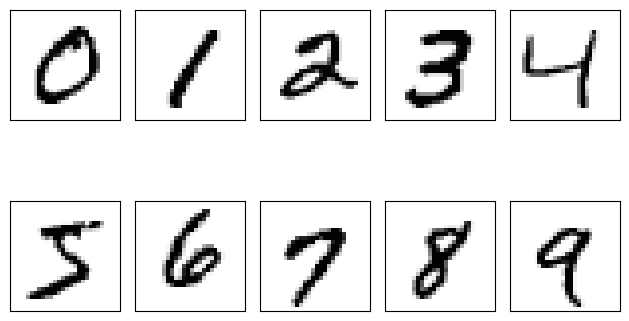

In [ ]:
#week4_1.txt 각 클래스의 첫번째 이미지 출력
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_5.png', dpi=300)
plt.show()

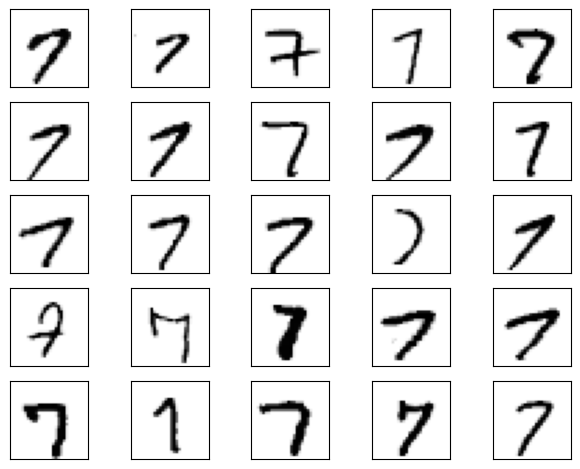

In [ ]:
#week4_2.txt 숫자 7 샘플 25개를 그립니다:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_6.png', dpi=300)
plt.show()

In [ ]:
import numpy as np
np.savez_compressed('mnist_scaled.npz',
                   X_train=X_train, y_train=y_train,
                   X_test=X_test, y_test=y_test)

In [ ]:
mnist = np.load('mnist_scaled.npz')
mnist.files

['X_train', 'y_train', 'X_test', 'y_test']

In [ ]:
X_train, y_train = mnist['X_train'], mnist['y_train']
X_test, y_test = mnist['X_test'], mnist['y_test']

del mnist

print(X_train.shape)

(60000, 784)


In [ ]:
n_epochs = 200

nn = NeuralNetMLP(n_hidden=30, epochs=n_epochs, eta=0.01,
                  minibatch_size=100, l2=0.01,
                  shuffle=True, seed=1)

nn.fit(X_train=X_train[:55000], y_train=y_train[:55000],
       X_valid=X_train[55000:], y_valid=y_train[55000:])

Epochs: 200/200 | Cost: 13211.16 | 훈련/검증 정확도: 96.79%/96.16% 

In [ ]:
def save_model(model, filename):
    np.savez(filename,
             w_h=model.w_h, b_h=model.b_h,
             w_out=model.w_out, b_out=model.b_out)

save_model(nn, path + '/neural_network_model_200.npz')

In [ ]:
def load_model(filename):
    npzfile = np.load(filename)
    model = NeuralNetMLP()
    model.w_h = npzfile['w_h']
    model.b_h = npzfile['b_h']
    model.w_out = npzfile['w_out']
    model.b_out = npzfile['b_out']
    return model

loaded_model = load_model(path + 'neural_network_model.npz')

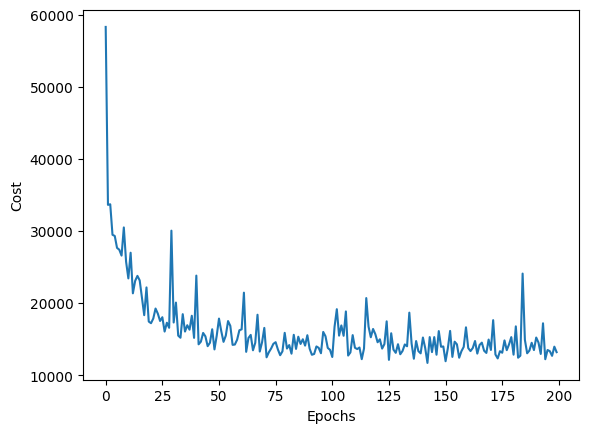

In [ ]:
#week4_3.txt
import matplotlib.pyplot as plt

plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
# plt.savefig('images/12_07.png', dpi=300)
plt.show()

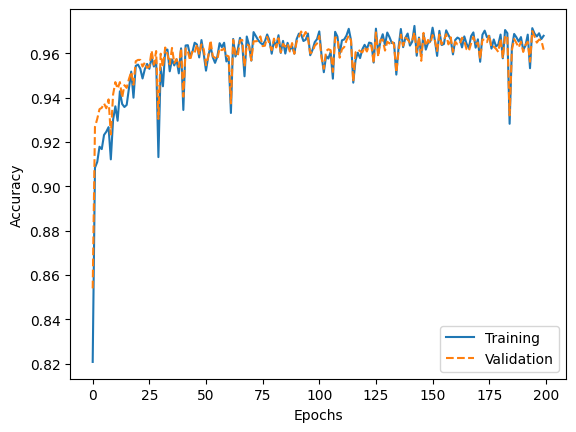

In [ ]:
#week4_4.txt
plt.plot(range(nn.epochs), nn.eval_['train_acc'],
        label='Training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'],
        label='Validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
# plt.savefig('images/12_08.png', dpi=300)
plt.show()

In [ ]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred) / X_test.shape[0])
print('테스트 정확도: %.2f%%' % (acc * 100))

테스트 정확도: 95.54%


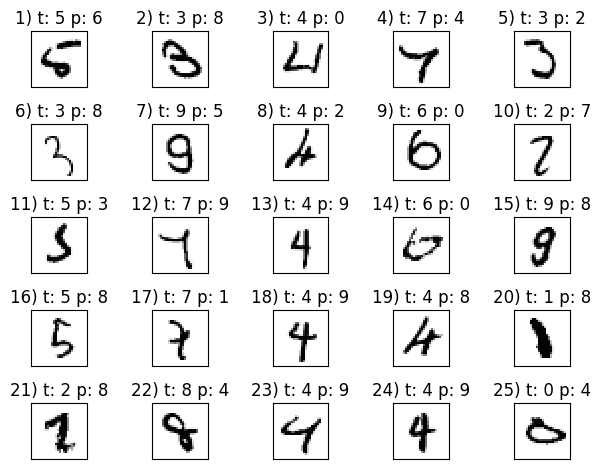

In [ ]:
#week4_5.txt
#miscl_img: y_test(타겟값) 과 y_test_pred(예측값)이 일치하지 않은 샘플의 이미지 데이터를 저장
#correct_lab: 타겟값과 예측값이 일치하지 않은 샘플의 타겟값 저장
#miscl_lab: 타겟값과 예측값이 일치하지 않은 샘플의 예측값 저장
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img,cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i + 1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_09.png', dpi=300)
plt.show()